
Processing U11.SI...


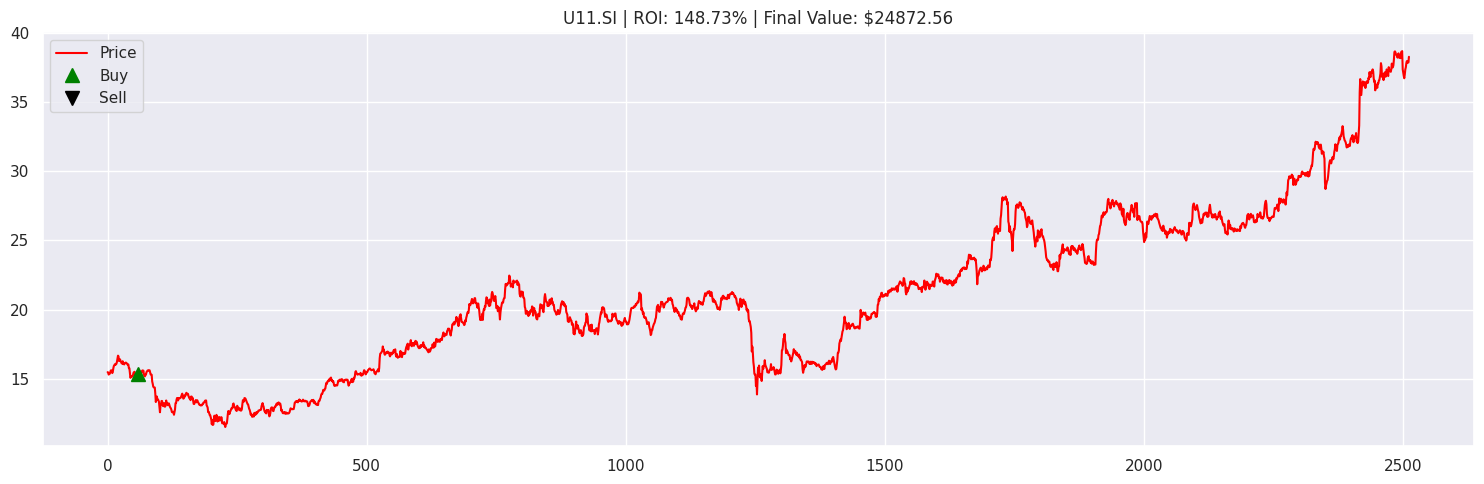


Processing C38U.SI...


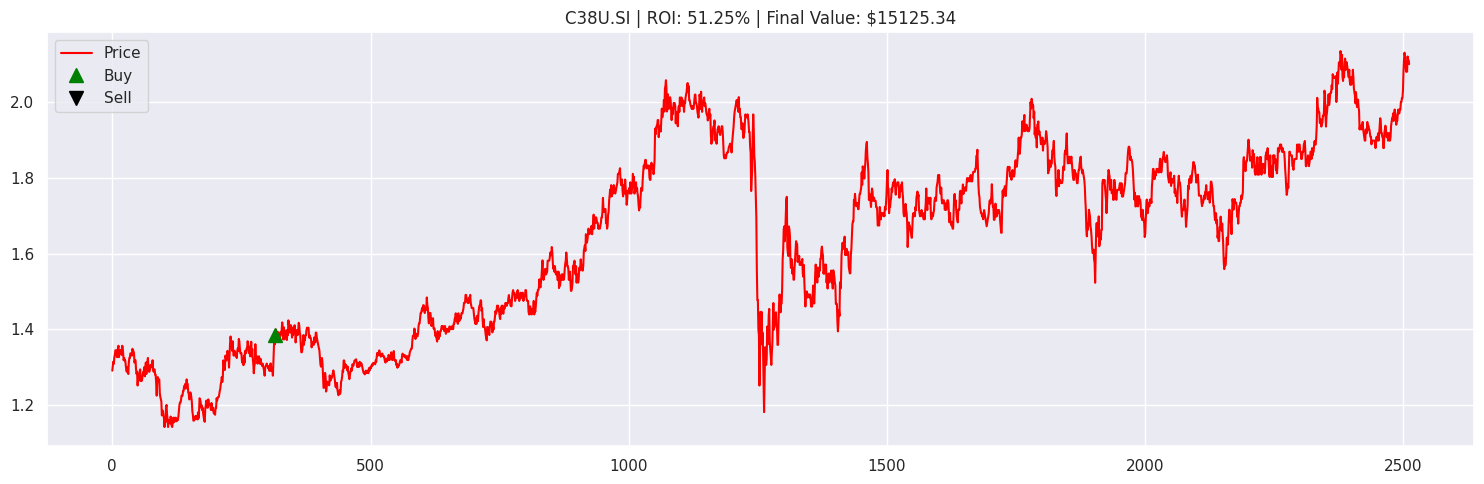


Processing Q0F.SI...


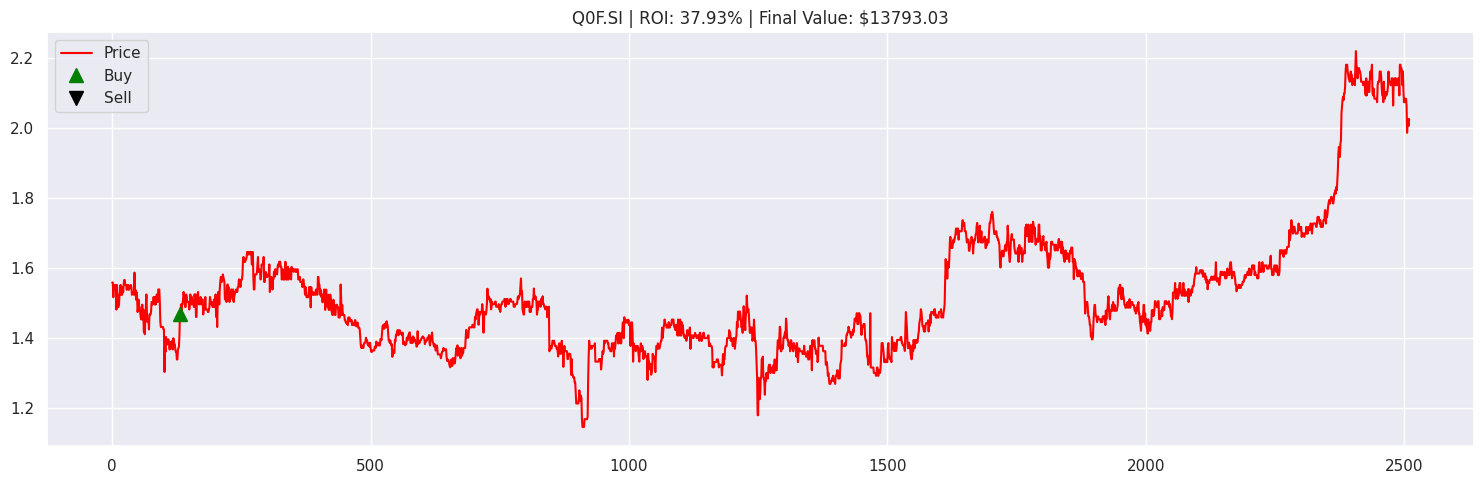


Processing S68.SI...


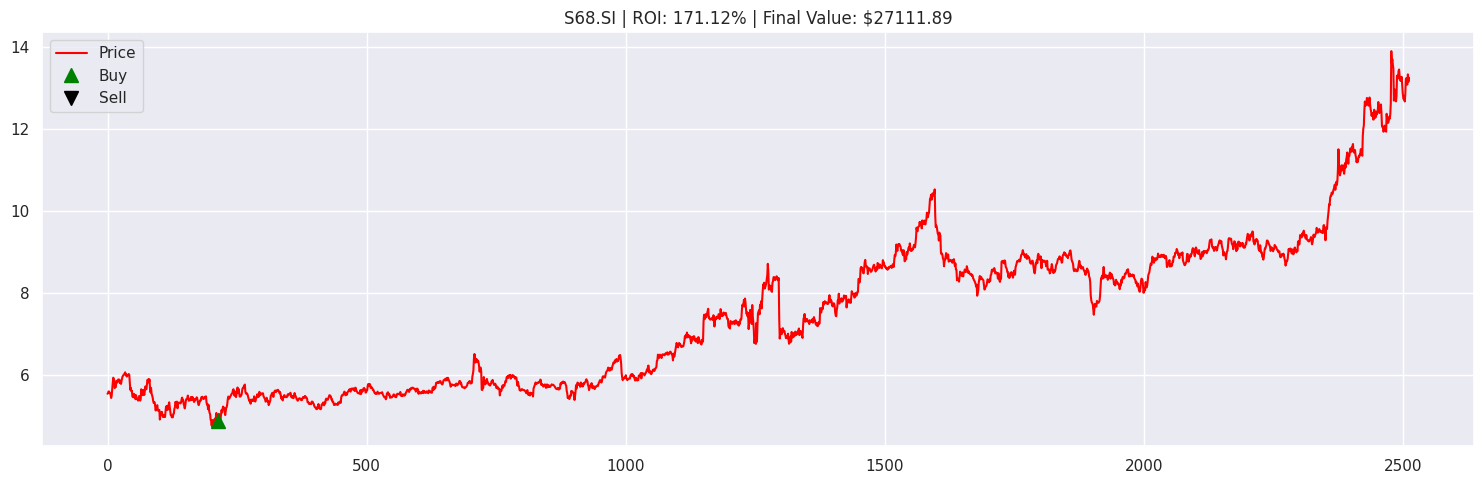


Processing S63.SI...


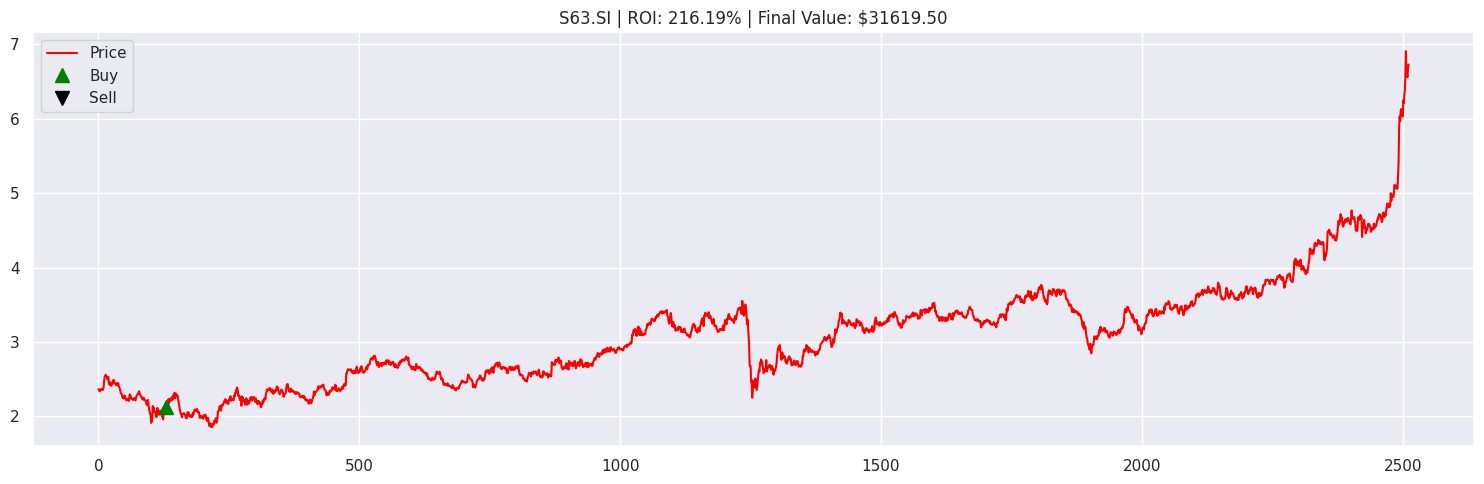


Processing AJBU.SI...


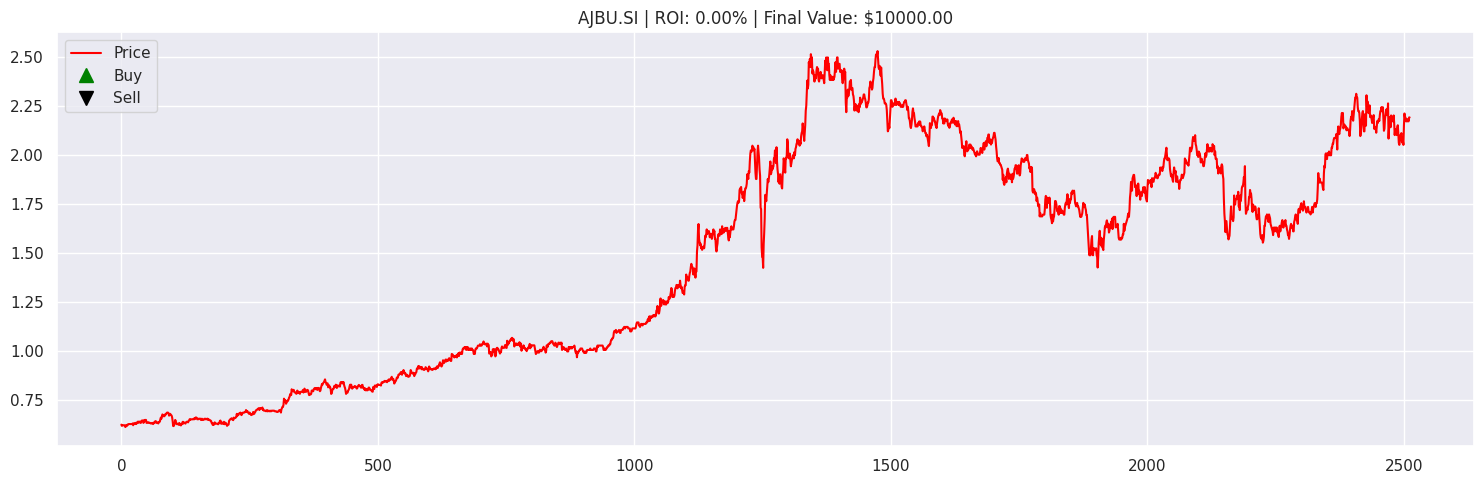


Portfolio Summary:
                ROI   Final Value
U11.SI   148.725620  24872.561958
C38U.SI   51.253389  15125.338878
Q0F.SI    37.930266  13793.026617
S68.SI   171.118876  27111.887621
S63.SI   216.194974  31619.497392
AJBU.SI    0.000000  10000.000000


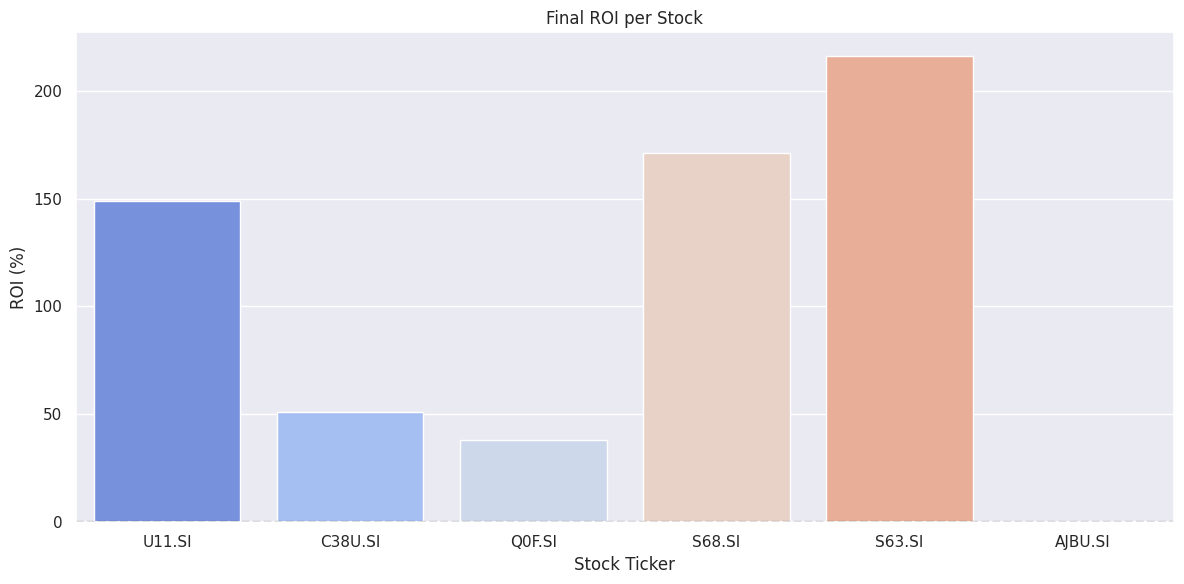

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import random

sns.set()

# Parameters
initial_money = 10000
window_size = 30
commission = 0.00125
alpha_threshold = 0.01
beta_threshold = -0.01
risk_rsi_low = 30
risk_rsi_high = 70
min_trade_profit = 0.005

# Indicator Functions
def RMA(series, period):
    rma = [series[0]]
    alpha = 1 / period
    for price in series[1:]:
        rma.append((1 - alpha) * rma[-1] + alpha * price)
    return np.array(rma)

def apply_second_order_rma(prices):
    return RMA(RMA(prices, 25), 9)

def compute_macd(prices, short=12, long=26, signal=9):
    ema_short = pd.Series(prices).ewm(span=short).mean()
    ema_long = pd.Series(prices).ewm(span=long).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=signal).mean()
    return macd_line.values, signal_line.values

def compute_rsi(prices, period=14):
    delta = np.diff(prices)
    up = np.where(delta > 0, delta, 0)
    down = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(up).rolling(window=period).mean()
    avg_loss = pd.Series(down).rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return np.concatenate([np.full(period, np.nan), rsi[period:]])

# DDPG Components
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x_initial if self.x_initial is not None else np.zeros_like(self.mean)

def get_actor(input_shape, action_dim):
    inputs = tf.keras.Input(shape=(input_shape,))
    out = tf.keras.layers.Dense(128, activation="relu")(inputs)
    out = tf.keras.layers.Dense(128, activation="relu")(out)
    outputs = tf.keras.layers.Dense(action_dim, activation="tanh")(out)
    return tf.keras.Model(inputs, outputs)

def get_critic(state_shape, action_dim):
    state_input = tf.keras.Input(shape=(state_shape,))
    action_input = tf.keras.Input(shape=(action_dim,))
    concat = tf.keras.layers.Concatenate()([state_input, action_input])
    out = tf.keras.layers.Dense(128, activation="relu")(concat)
    out = tf.keras.layers.Dense(128, activation="relu")(out)
    outputs = tf.keras.layers.Dense(1)(out)
    return tf.keras.Model([state_input, action_input], outputs)

class DDPGAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.actor = get_actor(state_dim, action_dim)
        self.critic = get_critic(state_dim, action_dim)
        self.target_actor = get_actor(state_dim, action_dim)
        self.target_critic = get_critic(state_dim, action_dim)
        self.actor_optimizer = tf.keras.optimizers.Adam(0.001)
        self.critic_optimizer = tf.keras.optimizers.Adam(0.002)
        self.noise = OUActionNoise(mean=np.zeros(action_dim), std_deviation=float(0.2) * np.ones(action_dim))
        self.memory = deque(maxlen=10000)
        self.gamma = 0.99
        self.tau = 0.005
        self.update_target_weights()

    def update_target_weights(self):
        self.target_actor.set_weights(self.actor.get_weights())
        self.target_critic.set_weights(self.critic.get_weights())

    def get_state(self, t, trend):
        d = t - window_size + 1
        block = trend[d:t+1] if d >= 0 else -d * [trend[0]] + trend[0:t+1]
        delta = [block[i+1] - block[i] for i in range(window_size - 1)]
        rma2 = apply_second_order_rma(block)[-1]
        macd_line, signal_line = compute_macd(block)
        rsi = compute_rsi(block)
        macd_diff = macd_line[-1] - signal_line[-1] if len(macd_line) else 0
        rsi_val = rsi[-1] if not np.isnan(rsi[-1]) else 50
        return np.array(delta + [rma2, macd_diff, rsi_val])

    def get_action(self, state):
        state = tf.convert_to_tensor(state.reshape(1, -1))
        action = self.actor(state)[0] + self.noise()
        return np.clip(action.numpy()[0], 0, 2).astype(int)

# Execution
portfolio_results = {}
tickers = {
    "U11.SI": "UOB Bank",
    "C38U.SI": "CapitaLand Integrated Commercial Trust",
    "Q0F.SI": "IHH Healthcare",
    "S68.SI": "SGX",
    "S63.SI": "ST Engineering",
    "AJBU.SI": "Keppel DC REIT"
}


for ticker in tickers:
    print(f"\nProcessing {ticker}...")
    df = pd.read_csv(f"/home/priya/Desktop/fyp/Agents/data_store/{ticker}.csv")
    df = df.dropna(subset=["Close"])  # Drop any NaNs in Close
    close = df['Close'].values.tolist()
    if len(close) < window_size + 20:
        print(f"Skipping {ticker} due to insufficient data.")
        continue

    agent = DDPGAgent(window_size - 1 + 3, 1)
    portfolio = initial_money
    shares_held = 0
    states_buy, states_sell = [], []

    for t in range(window_size, len(close) - 1):
        state = agent.get_state(t, close)
        action = agent.get_action(state)
        macd_line, signal_line = compute_macd(close[max(0, t-50):t+1])
        macd_diff = macd_line[-1] - signal_line[-1] if len(macd_line) else 0
        rsi = compute_rsi(close[max(0, t-50):t+1])
        rsi_val = rsi[-1] if not np.isnan(rsi[-1]) else 50

        current_price = close[t]
        expected_profit = close[t+1] * (1 - commission) - current_price * (1 + commission)

        if action == 1 and macd_diff > alpha_threshold and rsi_val < risk_rsi_high and expected_profit > min_trade_profit * current_price:
            if portfolio >= current_price * (1 + commission):
                shares_to_buy = portfolio // (current_price * (1 + commission))
                portfolio -= shares_to_buy * current_price * (1 + commission)
                shares_held += shares_to_buy
                states_buy.append(t)

        elif action == 2 and macd_diff < beta_threshold and rsi_val > risk_rsi_low and shares_held > 0:
            portfolio += shares_held * current_price * (1 - commission)
            shares_held = 0
            states_sell.append(t)

    portfolio_value = portfolio + shares_held * close[-1]
    roi = (portfolio_value - initial_money) / initial_money * 100
    portfolio_results[ticker] = {"ROI": roi, "Final Value": portfolio_value}

    plt.figure(figsize=(15, 5))
    plt.plot(close, label='Price', color='red')
    plt.plot(close, '^', markersize=10, color='green', label='Buy', markevery=states_buy)
    plt.plot(close, 'v', markersize=10, color='black', label='Sell', markevery=states_sell)
    plt.title(f"{ticker} | ROI: {roi:.2f}% | Final Value: ${portfolio_value:.2f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

results_df = pd.DataFrame(portfolio_results).T
print("\nPortfolio Summary:")
print(results_df)
results_df.to_csv('results_ddpg.csv')

plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y=results_df["ROI"], hue=results_df.index, dodge=False, palette="coolwarm", legend=False)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Final ROI per Stock")
plt.ylabel("ROI (%)")
plt.xlabel("Stock Ticker")
plt.tight_layout()
plt.show()